# Analysis of Cell Technology
3 competing cell technologies may claim marketshare in future; Bifacial PERC, bifacial SHJ, and Bifacial TOPCon. Each design has different efficiency and a different silver intensity. This analysis seeks compare these technologies on a mass and energy basis. A psuedo global deployment projection hitting 100% RE targets in 2050 is used so that silver demand can be evaluated at the global level.

Make 4+ scenarios
1. All PERC
2. All SHJ
3. All TOPCon
4. Realistic blend / ITRPV numbers from Martin Springer or Jarett Zuboy – DURAMat tech scounting report
5. All of the above and turn Bifacial ON/OFF

We will use the silver intensity and module efficiency projections from:

    Zhang, Yuchao, Moonyong Kim, Li Wang, Pierre Verlinden, and Brett Hallam. 2021. “Design Considerations for Multi-Terawatt Scale Manufacturing of Existing and Future Photovoltaic Technologies: Challenges and Opportunities Related to Silver, Indium and Bismuth Consumption.” Energy & Environmental Science. https://doi.org/10.1039/D1EE01814K. 

and

    Gervais, Estelle, Shivenes Shammugam, Lorenz Friedrich, and Thomas Schlegl. 2021. “Raw Material Needs for the Large-Scale Deployment of Photovoltaics – Effects of Innovation-Driven Roadmaps on Material Constraints until 2050.” Renewable and Sustainable Energy Reviews 137 (March): 110589. https://doi.org/10.1016/j.rser.2020.110589.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'CellTechCompare')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

# Data Preparation
Bring in the data from Zhang et al 2021 and Gervais et al 2021.

In [2]:
lit_celltech = pd.read_excel(os.path.join(supportMatfolder,'CellTechCompare','PERCvSHJvTOPCon-LitData.xlsx'), sheet_name='Sheet2',
                             header=[0,1,2], index_col=0)

In [3]:
lit_celltech.columns.get_level_values

<bound method MultiIndex.get_level_values of MultiIndex([('Zhang et al 2021 (hallam)',   'PERC',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',   'PERC', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)',    'SHJ',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',    'SHJ', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)', 'TOPCon',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)', 'TOPCon', 'Ag_mgpcell')],
           names=[None, None, 'year'])>

In [4]:
#Zhang et al Table 2 gives cell size assumptions 166mm cells
cell_size_m2 = np.square(0.166)

In [5]:
#calculate silver use per meter squared for each tech
zhang_perc_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['Ag_mgpcell']/1000/cell_size_m2 #creates series
zhang_shj_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['Ag_mgpcell']/1000/cell_size_m2
zhang_topcon_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['Ag_mgpcell']/1000/cell_size_m2

Gervais et al 2021 also project silver use, but through 2050. We wil use Zhang et al silver intensity through 2030, then a futher decrease from Gervais et al to 2050. There is no projection of TOPCon from Gervais et al, so we will assume a similar magnitude of continued decrease.

In [6]:
lit_celltech.loc[2030]

                                   year      
Zhang et al 2021 (hallam)  PERC    ModuleEff     24.5
                                   Ag_mgpcell    57.0
                           SHJ     ModuleEff     25.3
                                   Ag_mgpcell    99.0
                           TOPCon  ModuleEff     25.0
                                   Ag_mgpcell    95.0
Name: 2030, dtype: float64

In [7]:
Gervais_perc_2050 = pd.Series({2050:40}) #mg/cell
Gervais_shj_2050 = pd.Series({2050:80}) #mg/cell
guess_topcon_2050 = pd.Series({2050:(95-18)}) # mg/cell 99-80 = 19, 57-40 = 17, guess further 18mg decrease
#assuming the same cell size as Zhang et al (it isn't specified in Gervais)
Gervais_perc_2050_kgpm2 = Gervais_perc_2050/1000/cell_size_m2
Gervais_shj_2050_kgpm2 = Gervais_shj_2050/1000/cell_size_m2
guess_topcon_2050_kgpm2 = guess_topcon_2050/1000/cell_size_m2

In [8]:
perc_Ag_kgpm2 = pd.concat([zhang_perc_Ag_kgpm2.loc[:2049], Gervais_perc_2050_kgpm2])
shj_Ag_kgpm2 = pd.concat([zhang_shj_Ag_kgpm2.loc[:2049], Gervais_shj_2050_kgpm2])
topcon_Ag_kgpm2 = pd.concat([zhang_topcon_Ag_kgpm2.loc[:2049], guess_topcon_2050_kgpm2])

In [9]:
#filled projections 2020 through 2050
perc_Ag_kgpm2.interpolate(inplace=True)
shj_Ag_kgpm2.interpolate(inplace=True)
topcon_Ag_kgpm2.interpolate(inplace=True)

Now lets use Zhang et al's projections of efficiency increases. These are reasonably ambitious, achieving ~25% by 2030, but PV is usually an overachiever. We will hold efficiency constant after 2030.

In [10]:
zhang_perc_modeff = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['ModuleEff']
zhang_shj_modeff = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['ModuleEff']
zhang_topcon_modeff = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['ModuleEff']

In [11]:
zhang_perc_modeff.interpolate(inplace=True)
zhang_shj_modeff.interpolate(inplace=True)
zhang_topcon_modeff.interpolate(inplace=True)

In [12]:
modeffs = pd.concat([zhang_perc_modeff,zhang_shj_modeff,zhang_topcon_modeff], axis=1)
modeffs.columns=['PERC','SHJ','TOPCon']
Aguse = pd.concat([perc_Ag_kgpm2,shj_Ag_kgpm2,topcon_Ag_kgpm2], axis=1)
Aguse.columns=['PERC','SHJ','TOPCon']

Text(0, 0.5, 'Module Efficiency [%]')

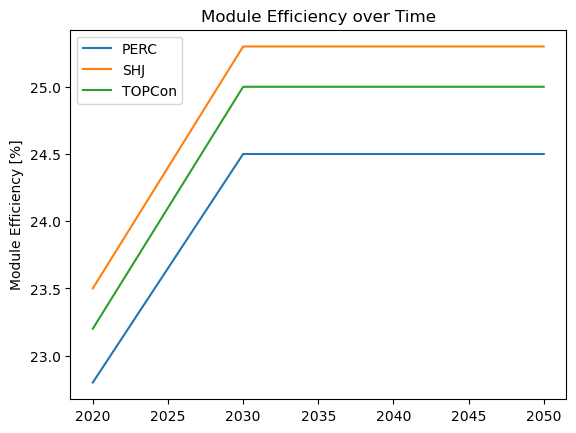

In [13]:
plt.plot(modeffs, label=modeffs.columns)
plt.legend()
plt.title('Module Efficiency over Time')
plt.ylabel('Module Efficiency [%]')

Text(0, 0.5, 'Silver Intensity [kg/m2]')

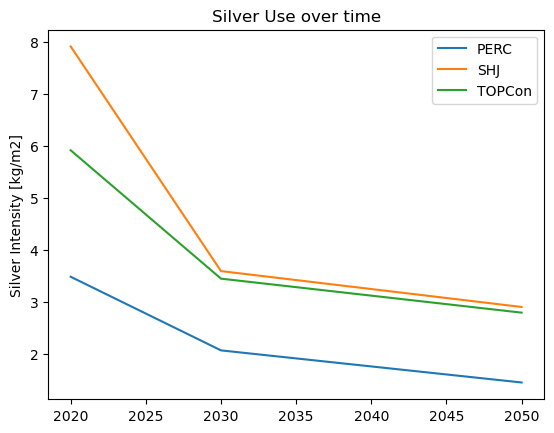

In [14]:
plt.plot(Aguse, label=Aguse.columns)
plt.legend()
plt.title('Silver Use over time')
plt.ylabel('Silver Intensity [kg/m2]')

One important aspect of these technologies is bifaciality. Each has a different bifaciality factor, and they are not expected to increase substantially with time (ITRPV 2022). We plan to explore monofacial and bifacial modules of these technologies (for example residential vs utility). We will use a static inventory of bifacial factors.

In [15]:
bifiFactors = {'PERC':0.7,
              'SHJ':0.9,
              'TOPCon':0.8} # ITRPV 2022, Fig. 58

In [16]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = Aguse.index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifi_perc = df_temp.copy()
bifi_perc['bifi'] = bifiFactors['PERC']
bifi_shj = df_temp.copy()
bifi_shj['bifi'] = bifiFactors['SHJ']
bifi_topcon = df_temp.copy()
bifi_topcon['bifi'] = bifiFactors['TOPCon']

In [17]:
bifi_perc.to_csv(path_or_buf=os.path.join(testfolder,'bifi_perc.csv'), index_label='Year')
bifi_shj.to_csv(path_or_buf=os.path.join(testfolder,'bifi_shj.csv'), index_label='Year')
bifi_topcon.to_csv(path_or_buf=os.path.join(testfolder,'bifi_topcon.csv'), index_label='Year')

In [18]:
bifi_perc_path = os.path.join(testfolder,'bifi_perc.csv')
bifi_shj_path = os.path.join(testfolder,'bifi_shj.csv')
bifi_topcon_path = os.path.join(testfolder,'bifi_topcon.csv')

To create a blended scenario, we will use the ITRPV 2022 cell market share projection through 2030, and then keep it constant through 2050.

In [19]:
#insert data from Jarett here
itrpv_celltech_marketshare = pd.read_csv(os.path.join(supportMatfolder,'CellTechCompare','ITRPV_celltech_marketshare.csv'), index_col=0)

In [20]:
itrpv_celltech_marketshare.columns
#there are more cell techs here than I need - I'm not currently concerned with n-type vs p-type
#the marketshares of "n-type back contact", "n-type other", "tandem si-based" are small and outside scope of study
#remove and renormalize.

Index(['p-type (Al-BSF)', 'p-type (PERC)', 'p-type (TOPCon)',
       'n-type (back contact)', 'n-type (SHJ)', 'n-type (TOPCon)',
       'n-type (other)', 'tandem (Si-based)'],
      dtype='object')

In [21]:
#subset for desired techs
celltech_marketshare_sub_raw = itrpv_celltech_marketshare.loc[2020:].filter(regex=('PERC|TOPCon|SHJ')) 
#interpolate to fill gaps
celltech_marketshare_sub_raw.interpolate(inplace=True, limit_direction='both')
#renormalize
celltech_marketshare_sub_raw['temp_sum'] = celltech_marketshare_sub_raw.iloc[:,[0,1,2,3]].sum(axis=1)
celltech_marketshare_sub_raw['scale'] = 1/celltech_marketshare_sub_raw['temp_sum'] #create scaling factor
celltech_marketshare_scaled = celltech_marketshare_sub_raw.iloc[:,[0,1,2,3]]*celltech_marketshare_sub_raw.loc[:,['scale']].values
#celltech_marketshare_scaled.sum(axis=1) # test check that everything adds to 1

In [22]:
celltech_marketshare_scaled.columns

Index(['p-type (PERC)', 'p-type (TOPCon)', 'n-type (SHJ)', 'n-type (TOPCon)'], dtype='object')

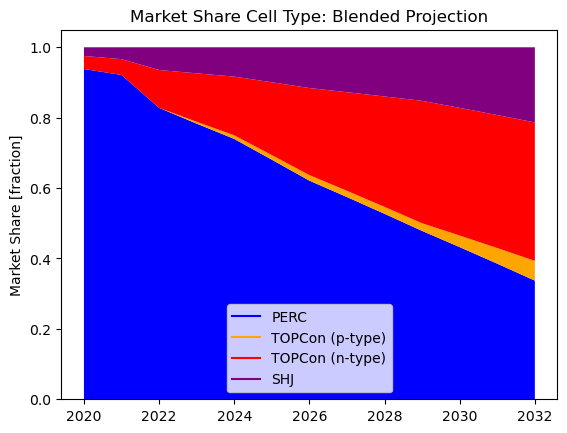

In [23]:
plt.plot([],[],color='blue', label='PERC')
plt.plot([],[],color='orange', label='TOPCon (p-type)')
plt.plot([],[],color='red', label='TOPCon (n-type)')
plt.plot([],[],color='purple', label='SHJ')
#plt.plot([],[],color='red', label='Cell')

plt.stackplot(celltech_marketshare_scaled.index,
              celltech_marketshare_scaled['p-type (PERC)'],
              celltech_marketshare_scaled['p-type (TOPCon)'],
              celltech_marketshare_scaled['n-type (TOPCon)'],
              celltech_marketshare_scaled['n-type (SHJ)'],
              colors = ['blue','orange','red','purple'])

plt.title('Market Share Cell Type: Blended Projection')
plt.ylabel('Market Share [fraction]')
#plt.xlim(1995,2022)
plt.legend(loc='lower center')
plt.show()

In [24]:
celltech_marketshare_scaled['TOPCon'] = celltech_marketshare_scaled.filter(like='TOPCon').sum(axis=1)

Other Assumptions:
- silicon wafer thickness is identical, and improvements are identical
- glass-glass module package for bifacial using 2.5mm glass for both
- module manufacturing energy is identical (until we get better data)
- degradation rates between the technologies are identical (until we get better data)
- Weibull Failure probabilities are identical between technologies (until we get better data)
- No ciruclarity

In [25]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2')

The mass per module area of glass is 12500.0 g/m^2


Pull in deployment projection. This deployment is based on the Solar Futures report, but has been modified to be more reasonable annual deployment schedule (i.e. manufacturing ramps up). However, this does not achieve 95% RE by 2035, but it does achieve 100% RE in 2050.

In [26]:
sf_reeds_alts = pd.read_excel(os.path.join(supportMatfolder,'SF_reeds_alternates.xlsx'),index_col=0)

In [27]:
sf_reeds = sf_reeds_alts.loc[2023:2050,['MW']]

In [28]:
#try sorting the Reeds Deployment to be in ascending order
sf_reeds['MW'].values.sort() #this sorts the column values in place

In [29]:
sf_reeds['TW_cum'] = sf_reeds['MW'].cumsum()/1e6

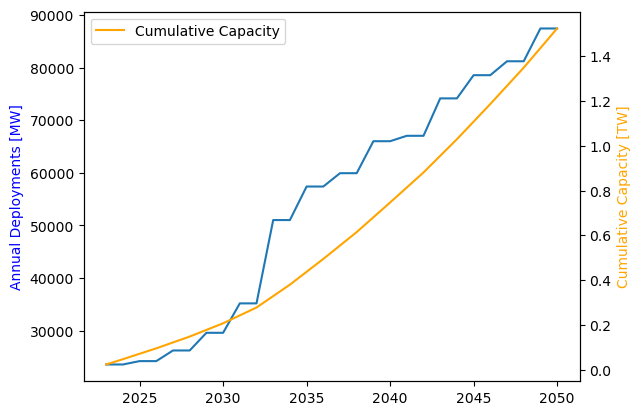

In [30]:
fig, ax1 = plt.subplots()

ax1.plot(sf_reeds['MW'])
ax1.set_ylabel('Annual Deployments [MW]', color='blue')

ax2 = ax1.twinx()
ax2.plot(sf_reeds['TW_cum'], color='orange')
ax2.set_ylabel('Cumulative Capacity [TW]', color='orange')

plt.legend(['Cumulative Capacity'])
plt.show()

In [31]:
sf_reeds.loc[2030]

MW        29613.993350
TW_cum        0.207411
Name: 2030.0, dtype: float64

In [32]:
sf_reeds.loc[2050]

MW        87426.894740
TW_cum        1.523311
Name: 2050.0, dtype: float64

In [33]:
#historical 2020-2022 from Wood Mac
history = sf_reeds_alts.loc[2020:2022,['Historically annual']]
history.columns=['MW']
projection = sf_reeds[['MW']]
newdeploymentcurve = pd.concat([history,projection],axis=0)

# Scenario Creation

In [34]:
scennames = ['PERC','SHJ','TOPCon'] #add later Blend and bifi on/off
MATERIALS = ['glass','aluminium_frames','silver','silicon', 'copper', 'encapsulant', 'backsheet']
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [35]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\CellTechCompare


Modify the all one tech scenarios Scenarios:

Module level
- trim to 2020-2050
- no circularity
- deployment projection
- module eff

material level
- glass per m2
- silver per m2

In [36]:
#trim to 2020-2050, this trims module and materials
sim1.trim_Years(startYear=2020)

endYear not provided. Setting to end year of Module data 2050


In [37]:
#no circularity
sim1.scenMod_noCircularity()

In [38]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

for scen in scennames:
    sim1.scenario[scen].dataIn_m.loc[0:len(newdeploymentcurve.index-1),'new_Installed_Capacity_[MW]'] = newdeploymentcurve.values

In [39]:
#module eff
#modeffs
for scen in scennames:
    sim1.scenario[scen].dataIn_m.loc[0:len(modeffs.index-1),'mod_eff'] = modeffs[scen].values

In [40]:
#glass modify
for scen in scennames:
    sim1.scenario[scen].material['glass'].matdataIn_m['mat_massperm2'] = glassperm2

In [41]:
#silver modify
#Aguse
for scen in scennames:
    sim1.scenario[scen].material['silver'].matdataIn_m.loc[0:len(Aguse.index-1),'mat_massperm2'] = Aguse[scen].values

In [42]:
sim1.scenario['PERC'].dataIn_m.head()

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff,mod_EOL_collected_recycled,mod_Reuse
0,2020,19914.550101,22.80,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
1,2021,24094.804465,22.97,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
2,2022,21893.147053,23.14,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
3,2023,23596.728960,23.31,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0
4,2024,23596.728960,23.48,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,40.0,0.0,100.0,60.0,0.0,0.0,40.0,0.0,0.0,0.0


In [43]:
sim1.scenario['PERC'].material['silver'].matdataIn_m.head()

,year,mat_virgin_eff,mat_massperm2,mat_MFG_eff,mat_MFG_scrap_Recycled,mat_MFG_scrap_Recycling_eff,mat_MFG_scrap_Recycled_into_HQ,mat_MFG_scrap_Recycled_into_HQ_Reused4MFG,mat_PG3_ReMFG_target,mat_ReMFG_yield,mat_PG4_Recycling_target,mat_Recycling_yield,mat_EOL_Recycled_into_HQ,mat_EOL_RecycledHQ_Reused4MFG,mod_EOL_p5_recycled,mat_EOL_Recycling_yield
0,2020,75.0,3.483815,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0
1,2021,75.0,3.342285,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0
2,2022,75.0,3.200755,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0
3,2023,75.0,3.059225,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0
4,2024,75.0,2.917695,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0


# Run Simulations

In [44]:
scennames
bifi_perc_path
bifi_shj_path 
bifi_topcon_path 

'C:\\Users\\hmirletz\\Documents\\GitHub\\PV_ICE\\PV_ICE\\TEMP\\CellTechCompare\\bifi_topcon.csv'

In [49]:
sim1.calculateFlows(scenarios='PERC', bifacialityfactors=bifi_perc_path)
sim1.calculateFlows(scenarios='SHJ', bifacialityfactors=bifi_shj_path)
sim1.calculateFlows(scenarios='TOPCon', bifacialityfactors=bifi_topcon_path)

perc_yearly, perc_cum = sim1.aggregateResults(scenarios='PERC')
shj_yearly, shj_cum = sim1.aggregateResults(scenarios='SHJ')
topcon_yearly, topcon_cum = sim1.aggregateResults(scenarios='TOPCon')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  alumin

In [59]:
sim1.plotMetricResults()

[]


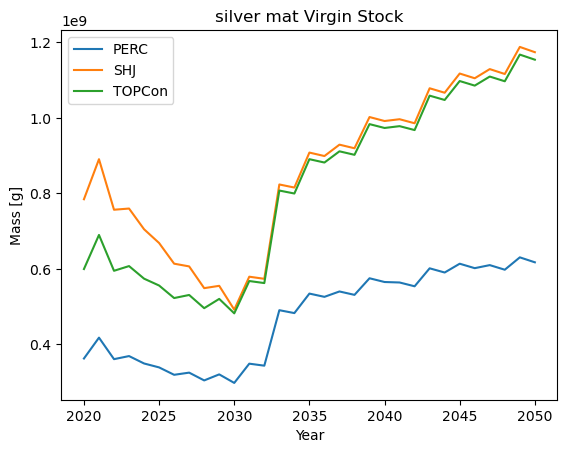

In [62]:
sim1.plotMaterialComparisonAcrossScenarios(keyword='mat_Virgin_Stock', material='silver')

In [80]:
sim1.scenario['PERC'].dataOut_e.loc[0:30,['e_out_annual_[Wh]']]

,e_out_annual_[Wh]
0,2.771659e+13
1,6.111257e+13
2,9.127735e+13
3,1.236623e+14
4,1.558854e+14
5,1.888376e+14
6,2.216250e+14
7,2.570626e+14
8,2.923228e+14
9,3.320769e+14


In [81]:
perc_energyGen_annual = sim1.scenario['PERC'].dataOut_e.loc[0:30,['e_out_annual_[Wh]']]
shj_energyGen_annual = sim1.scenario['SHJ'].dataOut_e.loc[0:30,['e_out_annual_[Wh]']]
topcon_energyGen_annual = sim1.scenario['TOPCon'].dataOut_e.loc[0:30,['e_out_annual_[Wh]']]
energyGen = pd.concat([perc_energyGen_annual, shj_energyGen_annual, topcon_energyGen_annual],axis=1)
energyGen.index=idx_temp

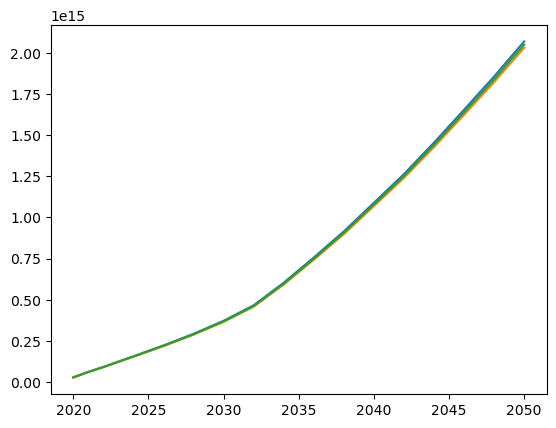

In [83]:
fig, ax1 = plt.subplots()

ax1.plot(energyGen)
#ax1.set_ylabel('Annual Deployments [MW]', color='blue')

#ax2 = ax1.twinx()
#ax2.plot(sf_reeds['TW_cum'], color='orange')
#ax2.set_ylabel('Cumulative Capacity [TW]', color='orange')

#plt.legend(['Cumulative Capacity'])
plt.title('Annual Energy Generation')
plt.show()